In [5]:
import rasterio
import numpy as np
import os

input_dir  = os.path.join('..', 'data_preproccesed')
output_dir = os.path.join('..', 'data_preproccesed')

# Pad naar je input en output
input_path  = os.path.join(input_dir, "slope_raw.tif")
output_path = os.path.join(output_dir, "slope_class_percentiles.tif")

# --- 1. Raster inlezen ---
with rasterio.open(input_path) as src:
    data = src.read(1).astype(float)
    profile = src.profile
    nodata = src.nodata

# --- 2. NoData naar NaN zetten ---
if nodata is not None:
    data[data == nodata] = np.nan

# --- 3. Percentielen berekenen ---
p25, p50, p75 = np.nanpercentile(data, [25, 50, 75])
print("Percentiles:", p25, p50, p75)

# --- 4. Classificatie ---
classified = np.zeros_like(data, dtype=np.uint8)

classified[(data < p25)] = 1
classified[(data >= p25) & (data < p50)] = 2
classified[(data >= p50) & (data < p75)] = 3
classified[(data >= p75)] = 4

# NoData terugzetten (0 is een nette keuze)
classified[np.isnan(data)] = 0

# --- 5. Output wegschrijven ---
profile.update(
    dtype=rasterio.uint8,
    nodata=0,
    count=1
)

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(classified, 1)

print("Klaar! Unieke waarden:", np.unique(classified))

with rasterio.open(output_path) as src_check:
    out = src_check.read(1)

print("Unique in classified (in memory):", np.unique(classified))
print("Unique in file (re-opened):       ", np.unique(out))
print("Pixels > 4 in file:", np.sum(out > 4))
print("Exact gelijk aan classified?:", np.array_equal(classified, out))



Percentiles: 0.05949339643120766 0.285620778799057 0.7934304177761078
Klaar! Unieke waarden: [0 1 2 3 4]
Unique in classified (in memory): [0 1 2 3 4]
Unique in file (re-opened):        [0 1 2 3 4]
Pixels > 4 in file: 0
Exact gelijk aan classified?: True


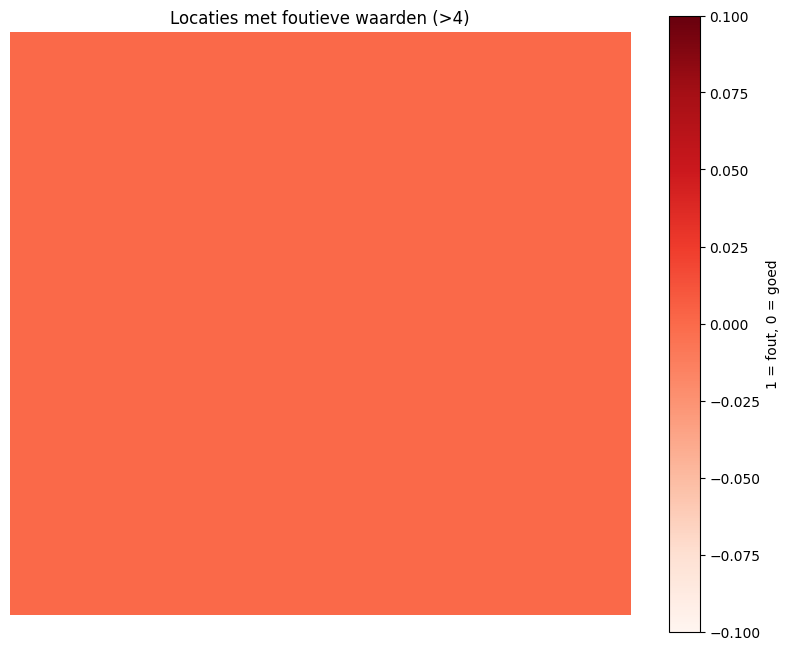

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

# Pad naar je geclassificeerde raster
input_path = os.path.join(input_dir, "slope_class_percentiles.tif")

# Raster inlezen
with rasterio.open(input_path) as src:
    data = src.read(1).astype(float)
    nodata = src.nodata

# NoData naar NaN
if nodata is not None:
    data[data == nodata] = np.nan

# Mask maken: 1 = fout (>4), 0 = goed (≤4)
mask = np.zeros_like(data, dtype=np.uint8)
mask[data > 4] = 1
mask[np.isnan(data)] = 0

# Visualisatie
plt.figure(figsize=(10, 8))
plt.imshow(mask, cmap="Reds", interpolation="nearest")
plt.title("Locaties met foutieve waarden (>4)")
plt.colorbar(label="1 = fout, 0 = goed")
plt.axis("off")
plt.show()
